In [19]:
# Basic imports
import pandas as pd
import numpy as np
import logging
import warnings
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# PyTorch imports
import torch

# PyTorch Tabular and Model imports (replace with correct imports based on your package structure)
from pytorch_tabular import TabularModel
from pytorch_tabular.models.category_embedding import CategoryEmbeddingModel

from pytorch_tabular.categorical_encoders import CategoricalEmbeddingTransformer
import sys
sys.path.append('../')
from src.data.process_data import load_dataset, split_dataset

# Suppress common warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [2]:
# Define the file paths to your datasets

data_path = '../data/'
drug_syn_path = os.path.join(data_path, 'drug_synergy.csv')
cell_lines_path = os.path.join(data_path, 'cell_lines.csv')
drug_portfolio_path = os.path.join(data_path, 'drug_portfolio.csv')

full_dataset_df, column_type_dict = load_dataset(drug_syn_path, cell_lines_path, drug_portfolio_path)

# Split the dataset into training, testing, and leaderboard sets
datasets = split_dataset(full_dataset_df)

categorical_cols = column_type_dict['categorical']['col_names']
continuous_cols = column_type_dict['numerical']['col_names']

In [3]:
# Path to the saved model checkpoint
model_path = "../model_weights/TabTransformer_model.ckpt"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)





2024-11-03 20:36:24,804 - {pytorch_tabular.tabular_model:165} - INFO - Experiment Tracking is turned off

2024-11-03 20:36:24,813 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

In [9]:
X = datasets['train']['X'][categorical_cols]
print(X.columns)
X_trans = transformer.transform(X)
print(X_trans.columns)

Output()

Index(['Cell line name', 'Compound A', 'Compound B',
       'GDSC tissue descriptor 2', 'MSI', 'Growth properties',
       'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B',
       'Function_B', 'Pathway_B'],
      dtype='object')


Index(['Cell line name_embed_dim_0', 'Cell line name_embed_dim_1',
       'Cell line name_embed_dim_2', 'Cell line name_embed_dim_3',
       'Cell line name_embed_dim_4', 'Cell line name_embed_dim_5',
       'Cell line name_embed_dim_6', 'Cell line name_embed_dim_7',
       'Cell line name_embed_dim_8', 'Cell line name_embed_dim_9',
       ...
       'Pathway_B_embed_dim_22', 'Pathway_B_embed_dim_23',
       'Pathway_B_embed_dim_24', 'Pathway_B_embed_dim_25',
       'Pathway_B_embed_dim_26', 'Pathway_B_embed_dim_27',
       'Pathway_B_embed_dim_28', 'Pathway_B_embed_dim_29',
       'Pathway_B_embed_dim_30', 'Pathway_B_embed_dim_31'],
      dtype='object', length=384)


In [18]:

# Dictionary to store unique embeddings for each element in each categorical column
unique_embeddings_dict = {}

for col in categorical_cols:
    # Identify embedding columns related to this categorical column
    embedding_cols = [c for c in X_trans.columns if c.startswith(f"{col}_embed_dim")]
    
    # Combine the original column with its embeddings
    combined_df = pd.concat([X[col].reset_index(drop=True), X_trans[embedding_cols].reset_index(drop=True)], axis=1)
    
    # Create a dictionary for this column where each key is a unique element, and value is the embedding as a numpy array
    col_embeddings = {val: group[embedding_cols].values[0] for val, group in combined_df.groupby(col)}
    
    # Store in the main dictionary
    unique_embeddings_dict[col] = col_embeddings
    
   

unique_embeddings_dict.keys()

dict_keys(['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'MSI', 'Growth properties', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B'])

PCA plot for 'Cell line name':


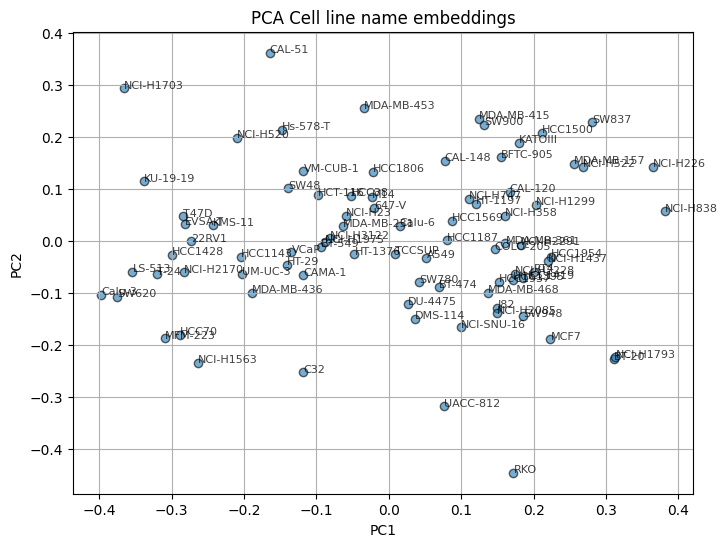

PCA plot for 'Compound A':


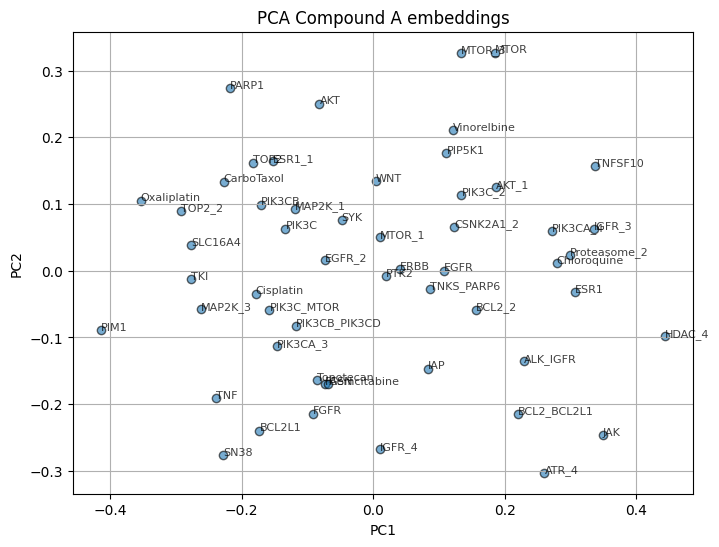

PCA plot for 'Compound B':


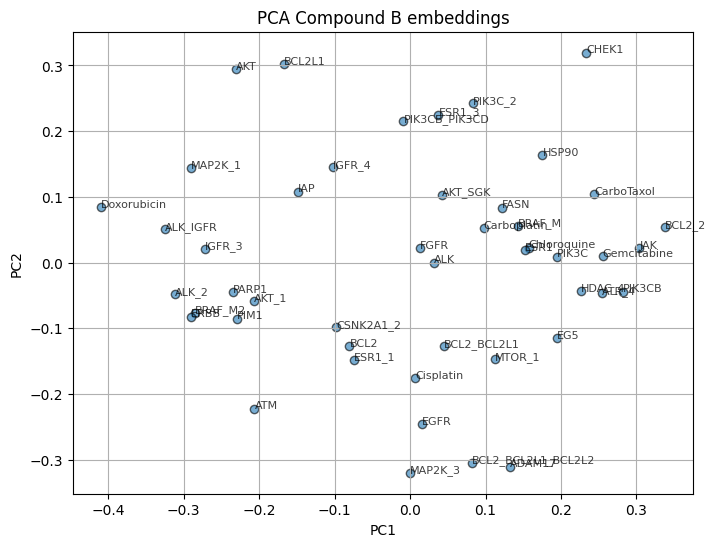

PCA plot for 'GDSC tissue descriptor 2':


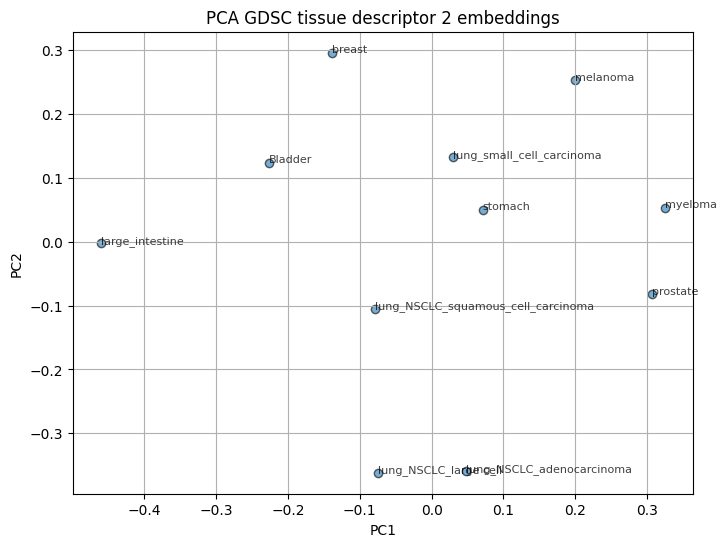

PCA plot for 'Putative target_A':


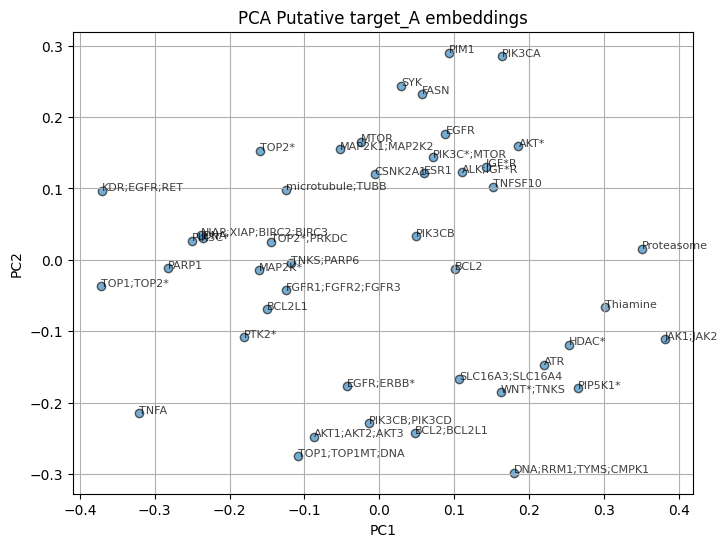

PCA plot for 'Function_A':


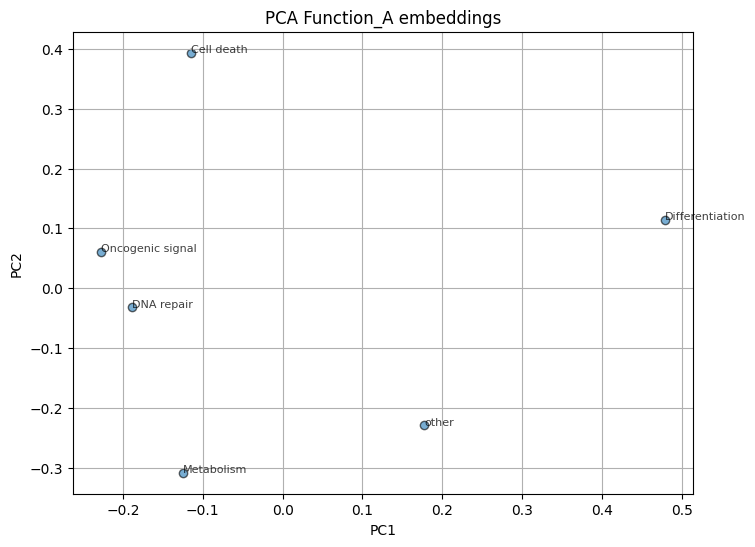

PCA plot for 'Pathway_A':


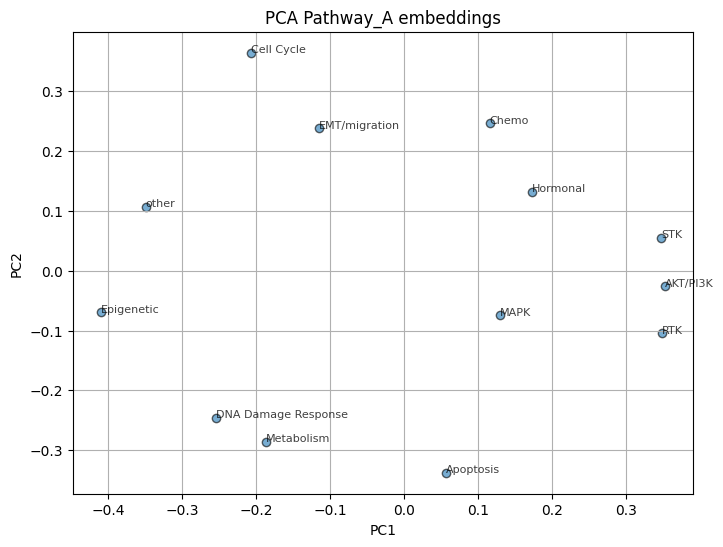

PCA plot for 'Putative target_B':


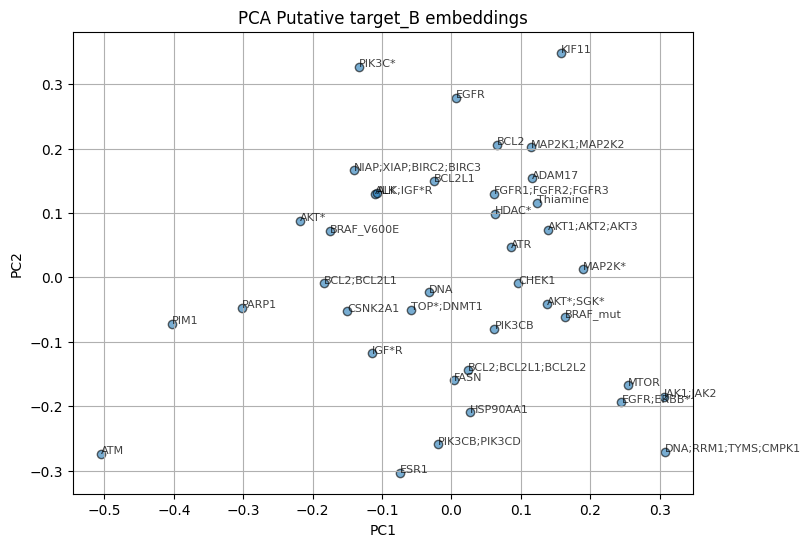

PCA plot for 'Function_B':


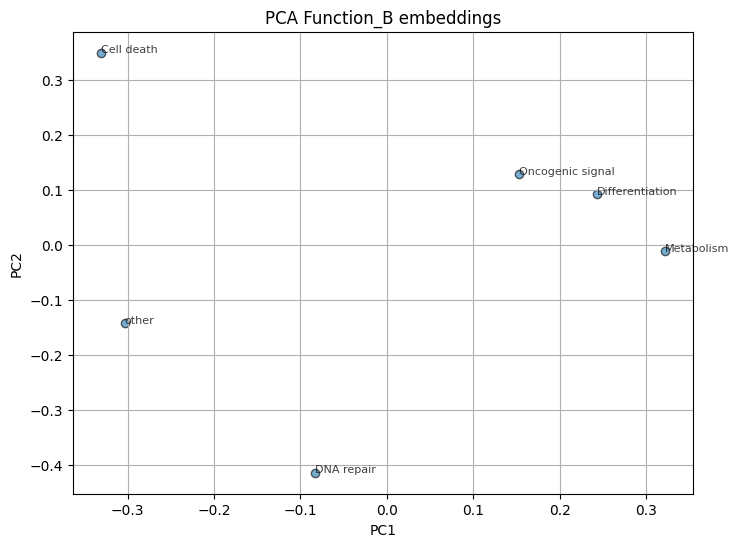

PCA plot for 'Pathway_B':


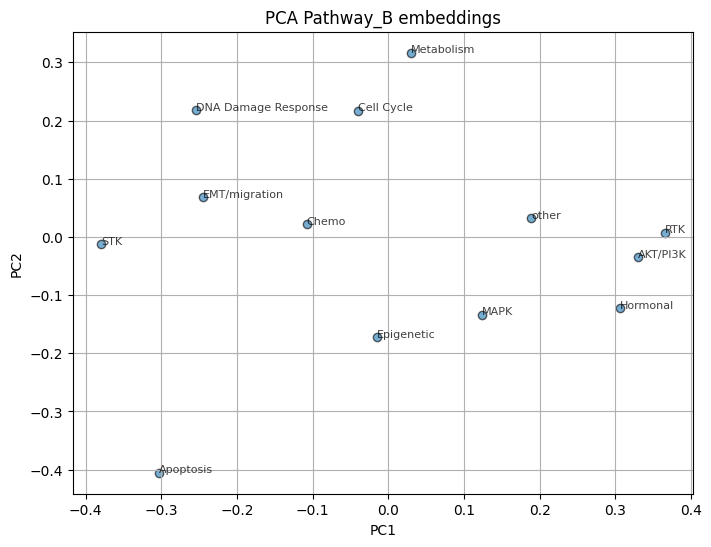

In [23]:


# Function to perform PCA and plot results
def plot_pca_embeddings(embeddings_dict, category_name, n_components=2):
    """
    Applies PCA to the embeddings of a categorical variable and plots the results.

    Parameters:
        embeddings_dict (dict): Dictionary containing unique items and their embeddings as numpy arrays.
        category_name (str): Name of the categorical variable.
        n_components (int): Number of PCA components to retain for plotting.
    """
    # Stack embeddings into a 2D array for PCA
    embeddings = np.stack(list(embeddings_dict.values()))
    labels = list(embeddings_dict.keys())
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    
    # Plotting the PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, edgecolors="k")
    
    # Annotate points with the unique category labels (optional, can be commented out if too crowded)
    for i, label in enumerate(labels):
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)
    
    plt.title(f"PCA {category_name} embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

pca_columns = ['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B']
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    print(f"PCA plot for '{category}':")
    plot_pca_embeddings(embeddings, category)
